In [4]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import pandas as pd
import os
import glob

import numpy as np

#코랩 환경
#from google.colab import files
#uploaded = files.upload()

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

라벨링 데이터 로드

In [18]:
# 뉴로서킷 라벨 엑셀 데이터 로드
# train 데이터 600개 + test 데이터 81개
df = pd.read_csv('drive/MyDrive/기사프/neurocircuit_label_data.csv')

# 두피 타입 O, C

In [3]:

# 예제코드
# dolphin_dir = '/dolphin/'
# shark_dir = '/shark/'
# whale_dir = '/whale/'

이미지 데이터 전처리
파이토치 라이브러리, albumentation 라이브러리 이용
데이터 커스터마이징 2가지 방식으로 진행

1. 이미지 resize
2. 스케일링을 준비
3. augmentation transform
4. data loader로 학습 진행

In [ ]:
class ScalpDataSet(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로
            root_dir (string): 모든 이미지가 존재하는 디렉토리 경로
            transform (callable, optional): 샘플에 적용될 Optional transform
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [16]:
# 
resize_trans = transforms.Compose([
                                   transforms.Resize((128,128)),
                                   transforms.ToTensor()
])

#데이터 불러오기
resize_data = torchvision.datasets.ImageFolder(root=df, transform=resize_trans)


TypeError: ignored

In [ ]:
resize_train[0][0].shape # ToTensor를 진행했기 때문에 데이터가 torch(C,H,W) 형태로 바뀜

In [ ]:
# numpy로 바꾸고, axis = 1,2 mean으로 RGB mean/std 뽑기
np.mean(resize_train[0][0].numpy(),axis=(1,2)) 

In [ ]:
def get_mean_std(dataset):
  meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
  stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])

  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])

  print(meanR, meanG, meanB)
  print(stdR, stdG, stdB)

In [ ]:
# normalization 준비

resize_train_mean=[0.17191947, 0.41128376, 0.56153077]
resize_train_std=[0.16150557, 0.16577946, 0.16063999]

resize_test_mean=[0.15918699, 0.410329, 0.55247366]
resize_test_std=[0.1542138, 0.16098696, 0.15552239]

1. transform을 이용해 data augmentation하기

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)), # 이미지 resize
    transforms.RandomCrop(124), # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 1), # p확률로 이미지 좌우반전
    transforms.RandomVerticalFlip(p = 1), # p확률로 상하반전
    transforms.ToTensor(),
    transforms.Normalize(resize_train_mean, resize_train_std)
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(resize_test_mean, resize_test_std)
])

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape

augmentation을 적용한 이미지 확인하기

In [20]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def imshow(img, mean, std):
    npimg = img.numpy()
    img = np.transpose( npimg, (1, 2, 0) )
    img = img * std + mean # renormalize
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.show()


none_trans = torchvision.datasets.ImageFolder(root=train_path, transform=None)

NameError: ignored

In [ ]:
# 원본 이미지
none_trans[359][0]

데이터 준비 End
Resnet 아키텍쳐 구성 부분

In [21]:
# import resnet
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [22]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 32 # conv1에서 나올 채널의 차원 -> 이미지넷보다 작은 데이터이므로 32로 조정

        # inputs = 3x224x224 -> 3x128x128로 바뀜
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False) # 마찬가지로 전부 사이즈 조정
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1) # 3 반복
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2) # 4 반복
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # input [32, 128, 128] -> [C ,H, W]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x.shape =[32, 64, 64]

        x = self.layer1(x)
        #x.shape =[128, 64, 64]
        x = self.layer2(x)
        #x.shape =[256, 32, 32]
        x = self.layer3(x)
        #x.shape =[512, 16, 16]
        x = self.layer4(x)
        #x.shape =[1024, 8, 8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [23]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 3, True).to(device) 
# resnet50
# 1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

구성한 아키텍쳐 확인

In [24]:
# 출력 tensor가 맞는지 확인해보자
from torchsummary import summary
summary(resnet50, input_size=(3, 128, 128), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           1,024
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,216
       BatchNorm2d-9           [-1, 32, 64, 64]              64
             ReLU-10           [-1, 32, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]           4,096
      BatchNorm2d-12          [-1, 128, 64, 64]             256
           Conv2d-13          [-1, 128, 64, 64]           4,096
      BatchNorm2d-14          [-1, 128,

In [25]:
#from torchvision import models
#import torch
#resnet50_pretrained = models.resnet50(pretrained=True)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 3, 3])


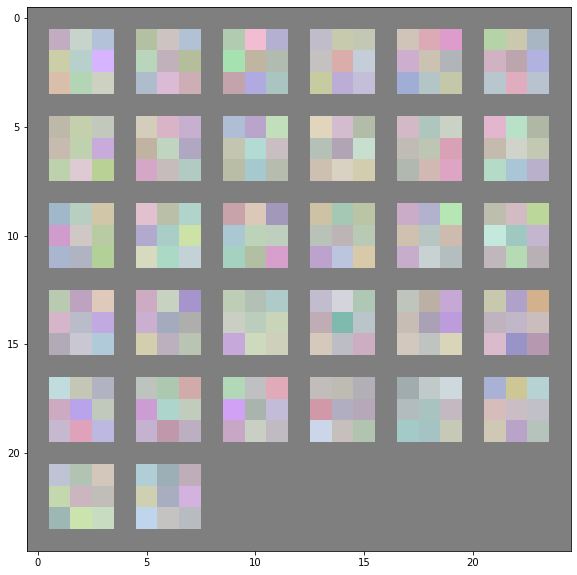

In [26]:
# 첫 번째 layer의 filter를 확인해보자 (=가중치 확인) -> 나중에 학습을 완료한 후의 filter도 확인하기
for w in resnet50.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# 가중치 renormalization
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=6, padding=1)

plt.figure(figsize=(10, 10))
imshow(x_grid)

파라미터 설정 및 train 진행

In [27]:
# config 모델 파라미터 인자를 만들기위한 클래스
class Config:
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

In [28]:
lr = 0.0008
epochs = 30
optimizer = 'Adam'

In [ ]:
# 파라미터 클래스
config = Config(
    trainloader = trainloader,
    testloader = testloader,
    model = resnet50,
    device = device,
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr),
    criterion= nn.CrossEntropyLoss().to(device),
    globaliter = 0
)

In [ ]:
class train_test():
      def __init__(self, config):
        # 파라미터 인자
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print(len(trainloader))
      def train(self, epochs, log_interval):
          self.model.train()
          for epoch in range(1, epochs + 1 ):  # epochs 루프
              running_loss = 0.0
              lr_sche.step()
              for i, data in enumerate(self.trainloader, 0): # batch 루프
                  # get the inputs
                  self.globaliter += 1
                  inputs, labels = data # input data, label 분리
                  inputs = inputs.to(self.device)
                  labels = labels.to(self.device)

                  # 가중치 초기화 -> 이전 batch에서 계산되었던 가중치를 0으로 만들고 최적화 진행
                  self.optimizer.zero_grad() 

                  # forward + backward + optimize
                  outputs = self.model(inputs)
                  loss = self.criterion(outputs, labels)
                  loss.backward()
                  self.optimizer.step()
                  running_loss += loss.item()

                  # 30 iteration마다 acc & loss 출력
                  if i % log_interval == log_interval -1 : # i는 1에포크의 iteration
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                        epoch, i*len(inputs), len(self.trainloader.dataset),
                        100. * i*len(inputs) / len(self.trainloader.dataset), 
                        running_loss / log_interval,
                        loss.item()))
                    running_loss = 0.0

                    #with train_summary_writer.as_default():
                    #    summary.scalar('loss', loss.item() , step = self.globaliter)

              with torch.no_grad():
                  self.model.eval()
                  correct = 0
                  total = 0
                  test_loss = 0
                  acc = []
                  for k, data in enumerate(self.testloader, 0):
                    images, labels = data
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(images)

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += self.criterion(outputs, labels).item()
                    acc.append(100 * correct/total)

                  print('\nTest set : Average loss:{:.4f}, Accuracy: {}/{}({:.0f}%)\n'.format(
                      test_loss, correct, total, 100 * correct/total
                  ))
                  #with test_summary_writer.as_default():
                  #    summary.scalar('loss', test_loss , step = self.globaliter)
                  #    summary.scalar('accuracy', 100 * correct/total , step = self.globaliter)  
##                      if acc [k] > 60 and acc[k] > acc[k-1]:
#                         torch.save({
#                                     'epoch': epoch,
#                                     'model_state_dict': self.model.state_dict(),
#                                     'optimizer_state_dict': self.optimizer.state_dict(),
#                                     'loss': test_loss
#                                     }, PATH)
                         
      print('Finished Training')

In [29]:
ready_to_train=train_test(config)

NameError: ignored

In [ ]:
lr_sche = optim.lr_scheduler.StepLR(config.optimizer, step_size=10000, gamma=0.5) # 20 step마다 lr조정
epochs = 200
log_interval = 175

ready_to_train.train(epochs, log_interval)